In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# -----------------------------------------------------------------
# Load Decision Tree bundle (adjust path if your notebook is elsewhere)
# -----------------------------------------------------------------
bundle_path = "../../Results/Visualizations/decision_tree_bundle.pkl"

with open(bundle_path, "rb") as f:
    dt_bundle = pickle.load(f)

print("Loaded bundle keys:", dt_bundle.keys())


Loaded bundle keys: dict_keys(['model_name', 'y_test', 'y_pred', 'y_proba', 'confusion_matrix', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'log_loss', 'roc_auc_ovr', 'params', 'dt_feature_importance', 'dt_feature_names', 'feature_names', 'X_test_sample'])


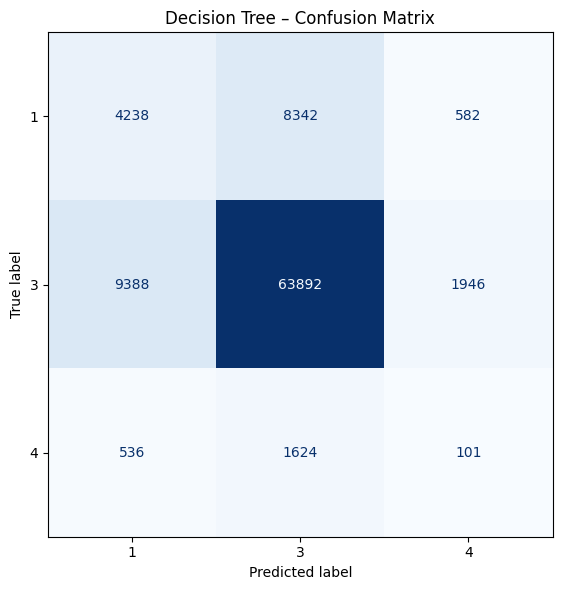

In [2]:
# -----------------------------------------------------------------
# Confusion Matrix plot for Decision Tree
# -----------------------------------------------------------------
cm = dt_bundle["confusion_matrix"]
y_test = dt_bundle["y_test"]

# Infer class labels from y_test
class_labels = np.unique(y_test)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=False)

ax.set_title("Decision Tree – Confusion Matrix")
plt.tight_layout()
plt.show()


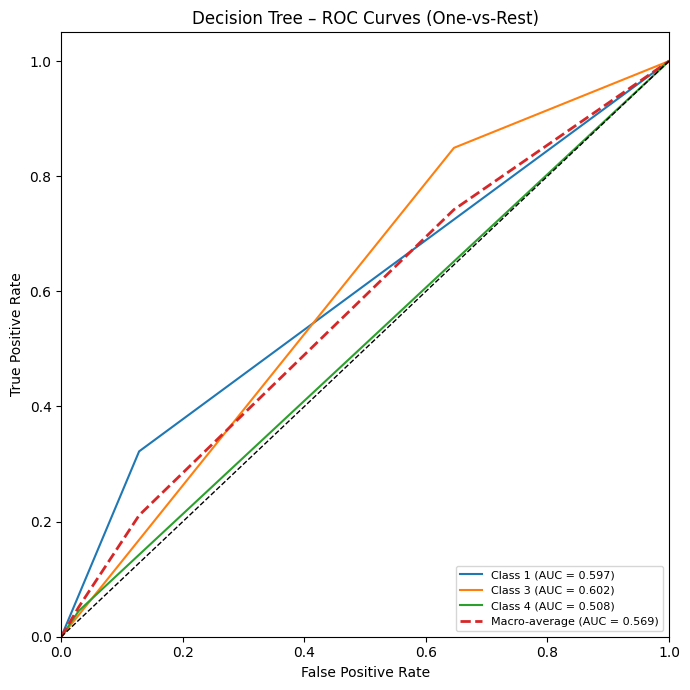

In [3]:
# -----------------------------------------------------------------
# ROC Curves for Decision Tree (one-vs-rest + macro average)
# -----------------------------------------------------------------
y_test = dt_bundle["y_test"]
y_proba = dt_bundle["y_proba"]

if y_proba is None:
    raise ValueError("y_proba is None in the bundle; cannot plot ROC curves.")

# Ensure numpy arrays
y_test = np.array(y_test)
y_proba = np.array(y_proba)

# Get class labels and binarize
classes = np.unique(y_test)
n_classes = len(classes)

y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[cls] for cls in classes]))
mean_tpr = np.zeros_like(all_fpr)

for cls in classes:
    mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(7, 7))

for cls in classes:
    plt.plot(
        fpr[cls],
        tpr[cls],
        lw=1.5,
        label=f"Class {cls} (AUC = {roc_auc[cls]:.3f})"
    )

plt.plot(
    all_fpr,
    mean_tpr,
    linestyle="--",
    linewidth=2,
    label=f"Macro-average (AUC = {roc_auc_macro:.3f})",
)

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree – ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()


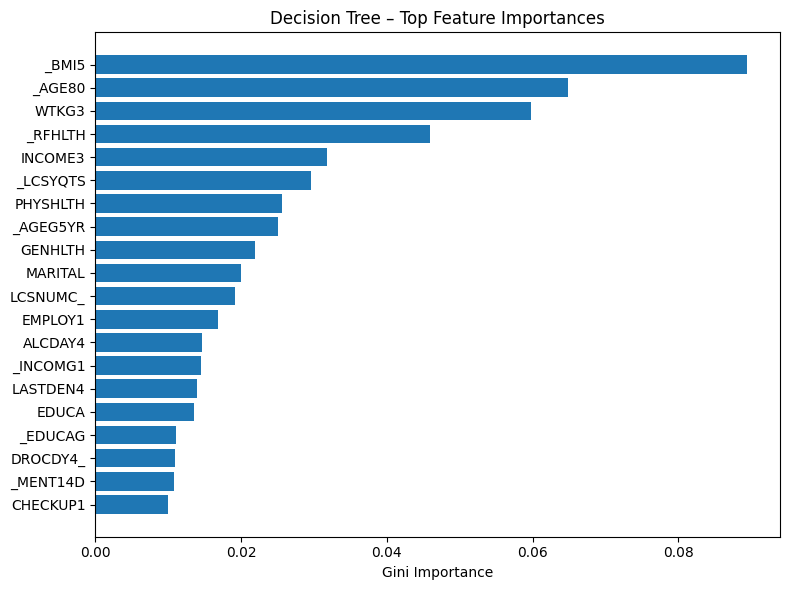

In [5]:
# -----------------------------------------------------------------
# Gini-based Feature Importance for Decision Tree
# -----------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

importances = dt_bundle["dt_feature_importance"]

# Try to get feature names in a safe way
feature_names = dt_bundle.get("dt_feature_names", None)
if feature_names is None:
    feature_names = dt_bundle.get("feature_names", None)

if feature_names is None:
    # Fallback: create generic names if we don't have real ones
    feature_names = np.array([f"feature_{i}" for i in range(len(importances))])
else:
    # Convert pandas Index / Series / list to numpy array
    feature_names = np.array(feature_names)

# Sort features by importance (descending)
idx = np.argsort(importances)[::-1]
sorted_importances = importances[idx]
sorted_features = feature_names[idx]

# Optionally, limit to top N for readability
top_n = 20
sorted_importances = sorted_importances[:top_n]
sorted_features = sorted_features[:top_n]

plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_importances)), sorted_importances[::-1])
plt.yticks(range(len(sorted_features)), sorted_features[::-1])
plt.xlabel("Gini Importance")
plt.title("Decision Tree – Top Feature Importances")
plt.tight_layout()
plt.show()



## 